# Studying Pt dependence of ML model

In this notebook, we would compare the Pt dependence of ML model to eratio. 

This is done by plotting the turn-on curve for each models at a specific cut value achieving 90% overall signal efficiency (ie. signal efficiency against electron truth pt curve)

In [1]:
# Importing required packages
import pickle
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib as mpl  


In [2]:
# mpl.rcParams['figure.figsize'] = [14.0, 10.0]
mpl.rcParams['font.size']=15
mpl.rcParams['figure.max_open_warning'] = 0
plt.style.use('seaborn-darkgrid')
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Importing data
ele_data = np.loadtxt('cut_ele_data.txt', delimiter = '	')
jet_data = np.loadtxt('cut_jet_data.txt', delimiter = '	')

ele_data_cell = []                          # array for ele cell information
ele_truthpt = []                            # array for ele truth pt
ele_eratio = []                             # array for ele eratio

for i in range (len(ele_data)):
    ele_data_cell.append(ele_data[i][12:])
    ele_truthpt.append(ele_data[i][2])
    ele_eratio.append(ele_data[i][11])
    
jet_data_cell = []                          # array for jet cell information
jet_truthpt = []                            # array for jet truth pt
jet_eratio = []                             # array for jet eratio

for i in range (len(jet_data)):
    jet_data_cell.append(jet_data[i][12:])
    jet_truthpt.append(jet_data[i][2])
    jet_eratio.append(jet_data[i][11])


# All Cell
sample = np.append(ele_data_cell, jet_data_cell, axis=0)

# Ele truth pt (col = 2)
sample_truthpt = np.append(ele_truthpt, jet_truthpt, axis=0)

print("Number of electron data", len(ele_data))
print("Number of jet data", len(jet_data))
print("Number of total data", len(sample))

Number of electron data 26261
Number of jet data 6593
Number of total data 32854


In [4]:
def convert2D(data):
    '''
    Function to convert data array into 2D picture
    
    Input: 
    data in shape (51,)
    
    Output: 
    data in picture shaped (3,17)
    '''
    array = []
    for i in range (len(data)):
        a = np.reshape(data[i], [3, 17])
        array.append(a)
    return np.array(array)

In [5]:
def mnorm(data):
    '''
    Function for normalise image data using maximum cell energy
    
    Input:
    data to be normalised
    Output:
    normalised data
    '''
    normdata=[]
    for i in range (len(data)):
        normdata.append(data[i]/np.max(data[i]))
    return np.asarray(normdata)

In [6]:
def snorm(data):
    '''
    Function for normalising image data using sum of cell energies
    
    Input:
    data = data to be normalised
    Output:
    Normalised data
    '''
    normdata=[]
    for i in range (len(data)):
        normdata.append(data[i]/np.sum(data[i]))
    return np.asarray(normdata)

# Plot

Firstly, using cut index for 90% signal efficiency, true electrons that are predicted as electrons are saved into an array. Then two histograms are plotted using the same bins range.
- Histogram plot for pt of true electrons
- Histogram plot for pt of predicted true electrons

Then for each bins, we can calculate the signal efficiency by division of (a) *no. of pred true ele* by (b) *no. of true ele*.

$$ sig = \frac{a}{b} $$

The signal efficiency against electron truth pt is then calculated.




1027/1027 [==============================] - 30s 3ms/step
original
ROC Score = 0.9539795167660104
Signal Efficiency: 0.9002
Rejection:         0.1059
Cut Value:         0.8514

1027/1027 [==============================] - 3s 3ms/step
normalised(max)
ROC Score = 0.9520659765793764
Signal Efficiency: 0.9009
Rejection:         0.1145
Cut Value:         0.8271

1027/1027 [==============================] - 8s 8ms/step
normalised(sum)
ROC Score = 0.9505396777878286
Signal Efficiency: 0.9006
Rejection:         0.1128
Cut Value:         0.7967

eratio
ROC Score = 0.8194620854798365
Signal Efficiency: 0.9002
Rejection:         0.3044
Cut Value:         0.8358



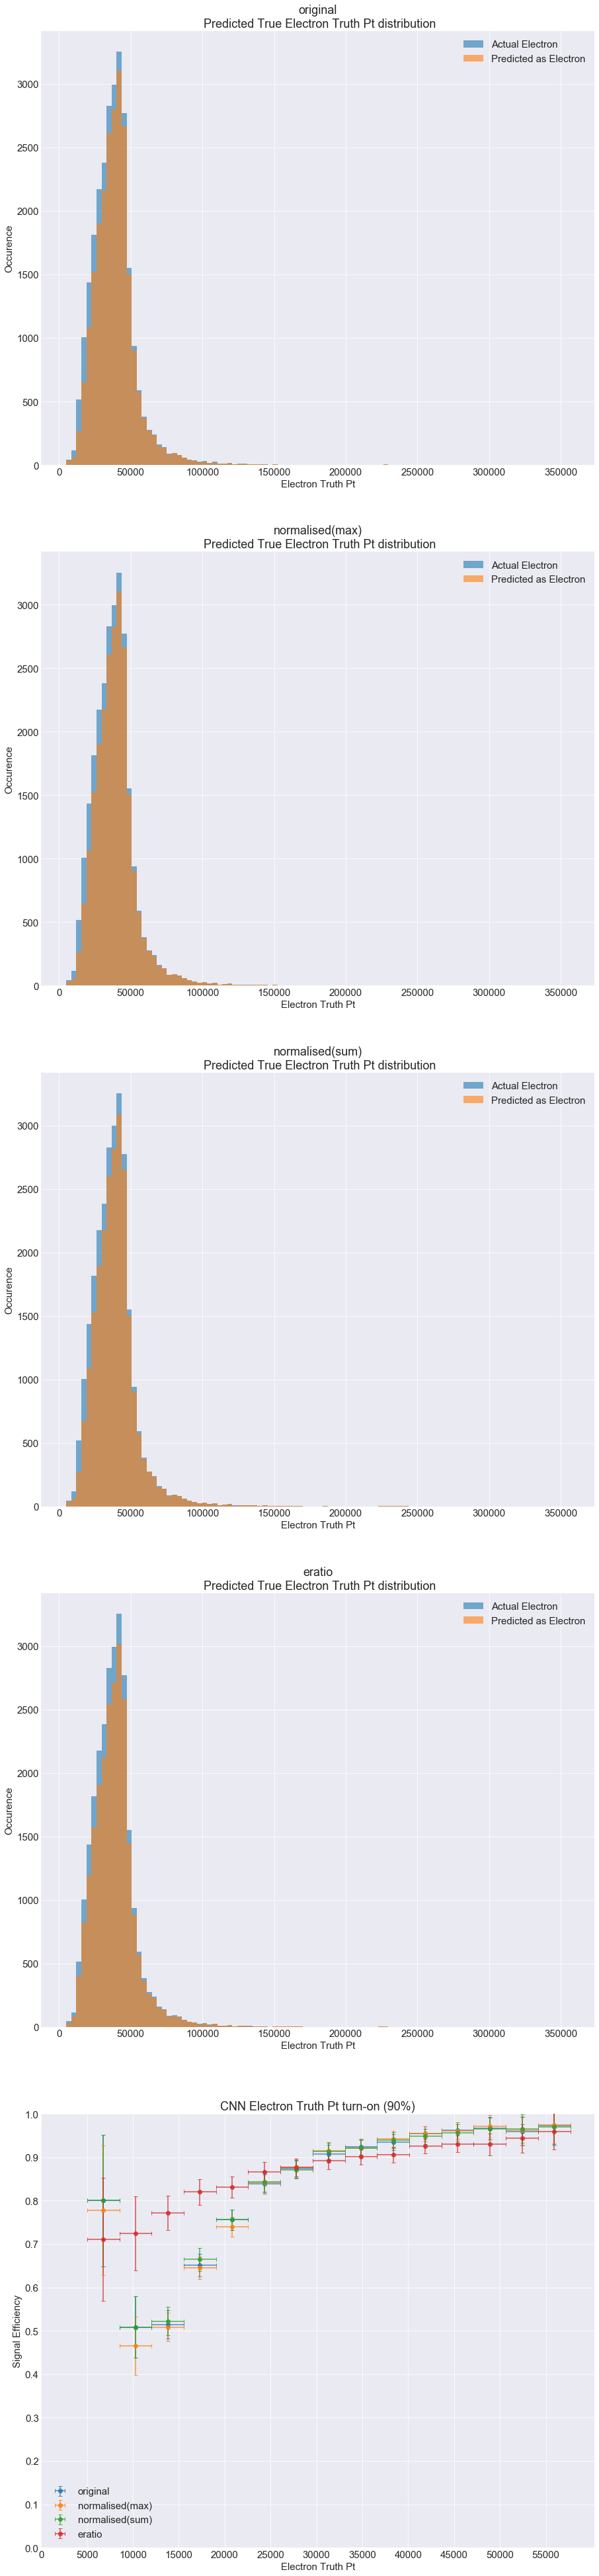

In [7]:
comparison = ["original", "normalised(max)", "normalised(sum)", "eratio"]

# Label data
ele_label = np.ones(26261)
jet_label = np.zeros(6593)
true_label = np.append(ele_label, jet_label, axis = 0)


fig, axs = plt.subplots(5,figsize=(15,70))


for i in range (len(comparison)):
    
    # For CNN (if other model is used below line should be "#")
    data = convert2D(sample)
    
    # For eratio
    if comparison[i] == 'eratio':
        prob = np.append(ele_eratio,jet_eratio, axis=0)
    
    # For ML models
    else:
        
        #Normalising data for mnorm and snorm models
        if comparison[i] == 'normalised(max)':
            data = mnorm(data)
        elif comparison[i] == 'normalised(sum)':
            data = snorm(data)
            
        # Loading saved models
        model_name = 'CNN' + comparison[i] + '.pickle'
        model = pickle.load(open(model_name, 'rb'))
        
        # Making prediction using model
        
        # For CNN
        prob = model.predict(data)
        
        # For other models
#         prob = model.predict_proba(data)[:,1]    
    


    # ROC Score
    print(comparison[i])

    roc_auc = roc_auc_score(true_label, prob)
    print("ROC Score =", roc_auc)
    fpr, tpr, thresholds = roc_curve(true_label, prob) 

    # Find 90% Cut Value and appending values after prediction

    cut_index = 0
    for j in range (len(tpr)):
        if tpr[j]>=0.90:
            cut_index=j
            break
    print("Signal Efficiency: {0:.4f}".format(tpr[cut_index]))
    print("Rejection:         {0:.4f}".format(fpr[cut_index]))
    print("Cut Value:         {0:.4f}".format(thresholds[cut_index]))
    
    
    
    # Model predictions for ele and jet separated
    prob_ele = prob[:26261]
    prob_jet = prob[26261:]
    
    # Appending truth pt values for ele that are predicted correctly
    true_ele_truthpt = []                           # array for ele truth pt

    for k in range (len(prob_ele)):
        if prob_ele[k] >= thresholds[cut_index]:
            true_ele_truthpt.append(ele_truthpt[k])


    ##### Ele truth pt #####
    tptbins = np.linspace(np.min(ele_truthpt), np.max(ele_truthpt), 101)                      # bins range for histogram
    
    # Electron
    n_ele, bins_ele, patches_ele = axs[i].hist(ele_truthpt,                                   # plot of actual ele
                                               bins=tptbins, 
                                               label='Actual Electron', 
                                               alpha=0.6)
    true_n_ele, true_bins_ele, true_patches_ele = axs[i].hist(true_ele_truthpt,               # plot of true positives
                                                              bins=tptbins, 
                                                              label='Predicted as Electron', 
                                                              alpha=0.6)
    
    axs[i].set_title(comparison[i] + '\n Predicted True Electron Truth Pt distribution')      # plot title
    axs[i].set(xlabel='Electron Truth Pt', ylabel='Occurence')                                # axis labels
    axs[i].legend(loc='best')                                                                 # show legend
    
    # Set turn-on range
    over_index = 0 
    for l in range (len(bins_ele)):
        if bins_ele[l] >= 55000:  # <- change this value for turn-on range
            over_index = l
            break
    
    
    # Find midpoints of bins
    midpointstart = (bins_ele[0]+bins_ele[1])/2
    midpointend = (bins_ele[-2]+bins_ele[-1])/2
    midpoints = np.linspace(midpointstart, midpointend, len(n_ele))
    
    # Calculation of signal efficiency for each bins
    sig = true_n_ele/n_ele

    # Uncertainty calculation
    true_n_ele_err = np.sqrt(true_n_ele)                                         # σ = /no of entries
    n_ele_err = np.sqrt(n_ele)                                                   # σ = /no of entries
    sig_err = sig*(np.sqrt((true_n_ele_err/true_n_ele)**2)+(n_ele_err/n_ele)**2) # uncertainty for signal efficiency
    x_err = (bins_ele[1]-bins_ele[2])/2                                          # uncertainty for truth pt

    # Turn-on plot
    axs[4].errorbar(midpoints[:over_index], 
                    sig[:over_index], 
                    yerr=sig_err[:over_index],  
                    xerr=x_err,
                    fmt='o',
                    capsize=3,
                    alpha=0.8,
                    label=str(comparison[i]))
    
    axs[4].set_title('CNN Electron Truth Pt turn-on (90%)')             # plot title
    axs[4].set(ylabel='Signal Efficiency', xlabel='Electron Truth Pt')  # axis labels
    axs[4].legend(loc='best')                                           # show legend
    axs[4].set_xticks(np.arange(0,60000,5000));                         # set x axis ticks
    axs[4].set_yticks(np.arange(0,1.1,0.1));                            # set y axis ticks
    axs[4].set_ylim(0, 1)                                               # set y axis limit
    
    

    print()

# For saving plots
extent = axs[4].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('Jz sample test/CNN/Turn-on Comparison (90%).pdf', bbox_inches=extent.expanded(1.2, 1.2))
plt.show()





# Saving Plots

The final plot of turn-on curve is saved into directory "'/Jz sample test/*model name*/*plot title*.pdf'